In [1]:
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
from simple_veloce_reduction import veloce_path, veloce_logs, veloce_extraction

Set up info about run and target(s)

In [3]:
data_dirs = {'red': 'ccd_3', 'green': 'ccd_2', 'blue': 'ccd_1'}

In [4]:
run = "CSV_Run"
veloce_paths = veloce_path.VelocePaths(run)
veloce_paths.__post_init__()

science_targets = ['HD20203-USQ01']

arm = 'green'

# Days and dates are redundant, should make one automatically generated from the other
dates = ['230826'] # can be drawn from dirs present in the run directory
days = ['26aug'] 

calib_type = 'SimLC' #['ARC-ThAr', 'SimThLong', 'SimTh', 'SimLC'] 
# it is mostly placeholder for now

# dict for filenames of the different types of frames taken
obs_list = {'science': {},
            'flat_red': {},
            'flat_green': {},
            'flat_blue': {},
            'dark': {},
            'bias': {},
            'wave_calib': {}}

Step 1 - read data filenames from logs

In [5]:
for day, date in zip(days, dates):
    log_path = os.path.join(veloce_paths.raw_parent_dir, run, date)
    log_name = [name for name in os.listdir(log_path) if name.split('.')[-1] == 'log'][0]
    log_path = os.path.join(log_path, log_name)
    temp_obs_list = veloce_logs.load_log_info(log_path, science_targets, arm, day, calib_type)
    for key in temp_obs_list:
        obs_list[key][date] = temp_obs_list[key]

Step 2 - save targets list

In [6]:
obs_list_name = veloce_logs.save_science_target_list(obs_list['science'], run=run)
# can be done also by target
# and with custom filename for resulting file

Step 3 - Extract science data


In [7]:
# output_path = veloce_paths.extracted_parent_dir
veloce_extraction.extract_run_no_blaze(obs_list_name, run, arm, veloce_paths=veloce_paths)#, output_path=output_path)

HD20203-USQ01 26aug20146.fits
HD20203-USQ01 26aug20147.fits
HD20203-USQ01 26aug20148.fits
HD20203-USQ01 26aug20149.fits
HD20203-USQ01 26aug20150.fits
HD20203-USQ01 26aug20151.fits
HD20203-USQ01 26aug20152.fits
HD20203-USQ01 26aug20153.fits
HD20203-USQ01 26aug20154.fits
HD20203-USQ01 26aug20155.fits
HD20203-USQ01 26aug20156.fits
HD20203-USQ01 26aug20157.fits
HD20203-USQ01 26aug20158.fits
HD20203-USQ01 26aug20159.fits
HD20203-USQ01 26aug20160.fits
HD20203-USQ01 26aug20161.fits
HD20203-USQ01 26aug20162.fits
HD20203-USQ01 26aug20163.fits


In [8]:
filename = os.listdir(veloce_paths.extracted_dir)[0]
spectrum = np.load(os.path.join(veloce_paths.extracted_dir, filename))

Text(0, 0.5, 'Flux [ADU]')

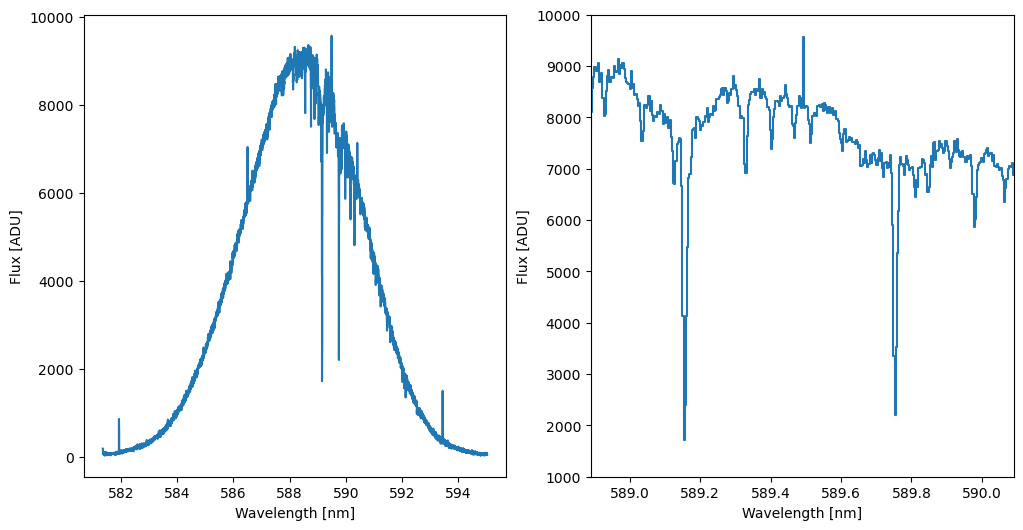

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].step(spectrum['wave'][1], spectrum['flux'][1], where='mid')
ax[0].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel('Flux [ADU]')
ax[1].step(spectrum['wave'][1], spectrum['flux'][1], where='mid')
plt.xlim(588.89, 590.09)
plt.ylim(1000, 10000)
ax[1].set_xlabel('Wavelength [nm]')
ax[1].set_ylabel('Flux [ADU]')

(optional) Step 4 - Make master flats (based on file list)

In [10]:
# master_type = f'flat_{arm}'

# for date in obs_list[master_type].keys():
#     if obs_list[master_type][date] != []:
#         master_flat = veloce_reduction_tools.get_master(obs_list,
#                             master_type, veloce_paths.raw_parent_dir, run, date, arm)
#         master_flat_filename =  f'master_{master_type}_{date}.fits'
#         fits.writeto(os.path.join(veloce_paths.master_dir, master_flat_filename),
#                     master_flat, header=None, output_verify='exception',
#                     overwrite=True, checksum=False)
#         veloce_extraction.extract_blaze(master_flat_filename, arm=f"{arm}")

In [11]:
# veloce_extraction.extract_blaze(master_flat_filename, arm=f"{arm}")